In [88]:
# import statements
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import sklearn
import glob
import random

def train_test_splitting(xarray_file):
    """
    Split model data into train and testing. 10 ensemble 
    members for each model are used for training as to 
    not over weight a given model. All remaining ensemble 
    members are used for testing.
    """
    # Find number of ensembles and random indicies of testing versus training ensembels
    Nensembles = len(xarray_file.ensemble_member)
    ensemble_train_indices = random.sample(range(0,Nensembles),9)
    ensemble_test_indices = list(set(list(range(0,Nensembles))).difference(ensemble_train_indices))

    # Select natural and forced trends as well as the training and testing data
    trend_data = xarray_file.to_array()[0]
    NatTrendsTrain = trend_data[ensemble_train_indices,0].to_numpy()
    NatTrendsTest = trend_data[ensemble_test_indices,0].to_numpy()
    ForTrendsTrain = trend_data[ensemble_train_indices,1].to_numpy()
    ForTrendsTest = trend_data[ensemble_test_indices,1].to_numpy()

    return(NatTrendsTrain, NatTrendsTest, ForTrendsTrain, ForTrendsTest)

def model_ensemble_reshaper(trends):
    """
    Takes a given models testing or trainging data and 
    reshapes it so that timeperiods from different ensembles
    of a given model are treated equally.
    """
    reshaped_trends = np.reshape(trends, (np.shape(trends)[0]*np.shape(trends)[1], 72,144))
    return(reshaped_trends)

def predictor_reshaper(trends):
    """
    Takes maps of trends and reshapes grid points into a vector.
    """
    PredictorVector = np.reshape(trends, (np.shape(trends)[0], np.shape(trends)[1]*np.shape(trends)[2]))
    return(PredictorVector)

def tropical_mean_trend(trends):
    """ 
    Takes map of trends and finds average over the 30S-30N region.
    """
    ReshapedTrends = np.reshape(trends[:,24:48,:], (np.shape(trends)[0],24*144))
    TropicalAverageTrend = np.average(ReshapedTrends, axis=1)
    return(TropicalAverageTrend)


path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/*.nc'
ModelDataFiles = glob.glob(path_to_data)

TraingPredictorData = []
TrainingTargetData = []
TestingPredictorData = []
TestingTargetData = []
for datafile in ModelDataFiles:
    xarray_file = xr.open_dataset(datafile) 
    # find training and testing data for natural and forced trends
    NatTrendsTrain, NatTrendsTest, ForTrendsTrain, ForTrendsTest = train_test_splitting(xarray_file)

    # reshape trends so that trend maps from different time periods and ensembles are treated equal
    NatTrendsTrain = model_ensemble_reshaper(NatTrendsTrain)
    NatTrendsTest = model_ensemble_reshaper(NatTrendsTest)
    ForTrendsTrain = model_ensemble_reshaper(ForTrendsTrain)
    ForTrendsTest = model_ensemble_reshaper(ForTrendsTest)

    # weight trend maps by cosine of latitude
    weights = np.cos(np.deg2rad(xarray_file.Lat.to_numpy())) # these will be used to weight predictors
    NatTrendsTrain_weighted = np.multiply(NatTrendsTrain, weights[np.newaxis,:,np.newaxis])
    NatTrendsTest_weighted = np.multiply(NatTrendsTest, weights[np.newaxis,:,np.newaxis])
    ForTrendsTrain_weighted = np.multiply(ForTrendsTrain, weights[np.newaxis,:,np.newaxis])
    ForTrendsTest_weighted = np.multiply(ForTrendsTest, weights[np.newaxis,:,np.newaxis])
    
    # true trend maps are sum of natural and forced trends
    TrueTrendsTrain = NatTrendsTrain_weighted + ForTrendsTrain_weighted
    TrueTrendsTest = NatTrendsTest_weighted + ForTrendsTest_weighted
    
    # reshape predictors as vector
    TrainingTrends_vectors = predictor_reshaper(TrueTrendsTrain)
    TestingTrends_vectors = predictor_reshaper(TrueTrendsTest)

    # find tropical mean trend value
    NatTrendsTrainTropicalMean = tropical_mean_trend(NatTrendsTrain_weighted)
    NatTrendsTestTropicalMean = tropical_mean_trend(NatTrendsTest_weighted)
    ForTrendsTrainTropicalMean = tropical_mean_trend(ForTrendsTrain_weighted)
    ForTrendsTestTropicalMean = tropical_mean_trend(ForTrendsTest_weighted)

    [TraingPredictorData.append(TrainingTrends_vectors[i]) for i in range(len(TrainingTrends_vectors))]
    [TrainingTargetData.append([NatTrendsTrainTropicalMean[i], ForTrendsTrainTropicalMean[i]]) 
    for i in range(len(ForTrendsTrainTropicalMean))]
    [TestingPredictorData.append(TestingTrends_vectors[i]) for i in range(len(TestingTrends_vectors))]
    [TestingTargetData.append([NatTrendsTestTropicalMean[i], ForTrendsTestTropicalMean[i]]) 
    for i in range(len(ForTrendsTestTropicalMean))]

TraingPredictorData = np.array(TraingPredictorData)
TrainingTargetData = np.array(TrainingTargetData)
TestingPredictorData = np.array(TestingPredictorData)
TestingTargetData = np.array(TestingTargetData)

In [98]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import model_selection

#X_train, X_test, y_train, y_test = train_test_split(input_to_model, output, test_size=0.2, random_state=42)
#y_test = np.array(y_test)
pls2 = PLSRegression(20)
pls_model = pls2.fit(TraingPredictorData, TrainingTargetData)
Y_pred = pls2.predict(TestingPredictorData)

0.79239329764118

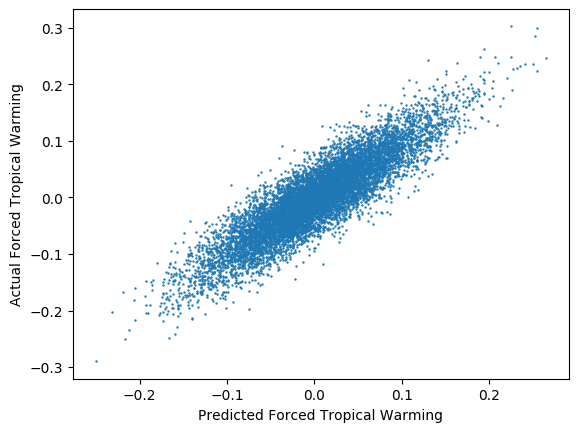

In [100]:
from scipy import stats
plt.scatter(Y_pred[:,0], TestingTargetData[:,0], s=0.5)
plt.xlabel('Predicted Forced Tropical Warming')
plt.ylabel('Actual Forced Tropical Warming')
#print(np.shape(Y_pred), np.shape(y_test))
stats.pearsonr(Y_pred[:,0], TestingTargetData[:,0])[0]**2


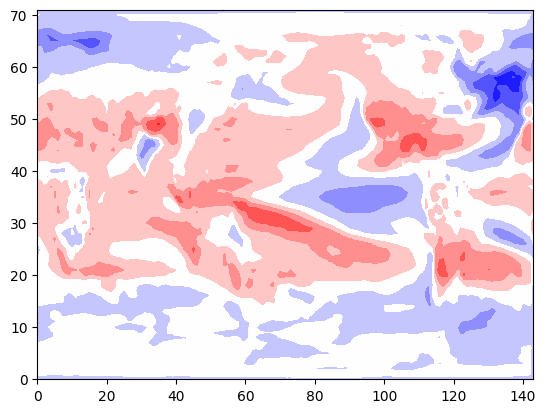

In [33]:
plt.contourf(np.reshape(pls_model.coef_[:,1], (72,144)), cmap='bwr')